In [305]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [306]:
df = pd.read_csv("../data/cars.csv",sep=",")

In [307]:
df.head()

,Make,Model,Price,ModelYear,FuelType,Reg,Kilometers,GearType,HorsePower
0,VW,ID.5,299900,2023,El,2023,9200,A,174
1,VW,e-Golf VII,149900,2018,El,2018,74000,A,136
2,VW,ID.Buzz,414900,2023,El,2023,5000,A,204
3,VW,ID.3,208900,2021,El,2020,49990,A,204
4,VW,e-Up!,119400,2021,El,2021,8000,A,82


## Data Exploration

In [308]:
len(df)

37285

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37285 entries, 0 to 37284
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Make        37285 non-null  object
 1   Model       37285 non-null  object
 2   Price       37285 non-null  int64 
 3   ModelYear   37285 non-null  int64 
 4   FuelType    37285 non-null  object
 5   Reg         37285 non-null  object
 6   Kilometers  37285 non-null  object
 7   GearType    37285 non-null  object
 8   HorsePower  37285 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.6+ MB


In [310]:
#Some columns need to be cleaned, like reg, kilomters and horsepowers as they should be numeric, and not object.

### cleaning numeric columns, to hold numeric values

In [311]:
df["Kilometers"].describe()

count        37285
unique        2708
top       (ny bil)
freq           497
Name: Kilometers, dtype: object

In [312]:
df['Kilometers'].str.contains('(ny bil)').value_counts()

/var/folders/jj/6mz63v6n0b5f1hlgmlnwgd7r0000gn/T/ipykernel_1400/2997597741.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['Kilometers'].str.contains('(ny bil)').value_counts()


False    36703
True       582
Name: Kilometers, dtype: int64

In [313]:
df["Kilometers"][119]

'(ny bil)'

In [314]:
df["Kilometers"][315]

'(ny bil) 1'

In [315]:
import re
def clean_kilometers(km):
    if isinstance(km, str):
        if km == "(ny bil)":
            return 0
        elif "(ny bil)" in km:
            match = re.search(r'\(ny bil\)\s*(\d+)', km)
            if match:
                return int(match.group(1))
            else:
                return 0
        else:
            return int(km)
    else:
        return int(km)

In [316]:
df['Kilometers'] = df['Kilometers'].apply(clean_kilometers)

In [317]:
df["Reg"].describe()

count     37285
unique       79
top        2023
freq       3991
Name: Reg, dtype: object

In [318]:
df['Reg'].str.contains('-').value_counts()

False    36753
True       532
Name: Reg, dtype: int64

In [319]:
df['Reg'][12619]

'-'

In [320]:
df['Reg'][12600]

'2024'

In [321]:
def clean_reg(reg, model_year):
    if reg == "-":
        return model_year
    else:
        return int(reg)

In [322]:
df['Reg'] = df.apply(lambda row: clean_reg(row['Reg'], row['ModelYear']), axis=1)

In [323]:
df['HorsePower'].str.contains('-').value_counts()

False    37200
True        85
Name: HorsePower, dtype: int64

In [324]:
df = df[~df['HorsePower'].str.contains('-/', na=False)]

In [325]:
df["HorsePower"] = df["HorsePower"].apply(int)

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37200 entries, 0 to 37284
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Make        37200 non-null  object
 1   Model       37200 non-null  object
 2   Price       37200 non-null  int64 
 3   ModelYear   37200 non-null  int64 
 4   FuelType    37200 non-null  object
 5   Reg         37200 non-null  int64 
 6   Kilometers  37200 non-null  int64 
 7   GearType    37200 non-null  object
 8   HorsePower  37200 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 2.8+ MB


## Data Exploration

In [327]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,Price,ModelYear,Reg,Kilometers,HorsePower
count,"37,200.00","37,200.00","37,200.00","37,200.00","37,200.00"
mean,"207,561.18","2,017.46","2,017.37","97,505.46",157.06
std,"159,530.74",5.80,5.77,"84,263.97",84.54
min,950.00,"1,925.00","1,925.00",0.00,11.00
25%,"99,900.00","2,015.00","2,015.00","27,000.00",100.00
50%,"174,166.00","2,018.00","2,018.00","83,000.00",136.00
75%,"279,800.00","2,021.00","2,021.00","147,000.00",190.00
max,"4,569,072.00","2,025.00","2,026.00","2,120,000.00",685.00


### Price

In [328]:
df['Price'].describe()

count      37,200.00
mean      207,561.18
std       159,530.74
min           950.00
25%        99,900.00
50%       174,166.00
75%       279,800.00
max     4,569,072.00
Name: Price, dtype: float64

Looks like we have some outliers, with the minimum being 950kr and the max being over 4.5m kr. This also tells us the the prices might be right-skewed, with a mean of around 200k, and a lower median of 174k which tells us that some high prices are pulling the prices up. The std is also quite high which further tells us that the prices vary

In [329]:
def currency_format(x, pos):
    return '{:,.0f}'.format(x)

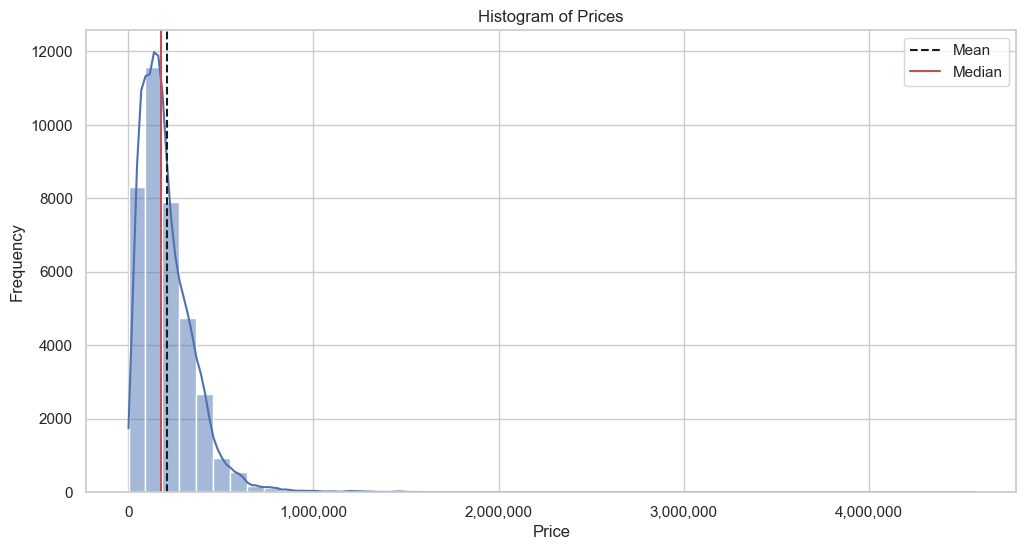

In [330]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['Price'], kde=True, bins=50)
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.axvline(df['Price'].mean(), color='k', linestyle='--', label='Mean')
plt.axvline(df['Price'].median(), color='r', linestyle='-', label='Median')
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

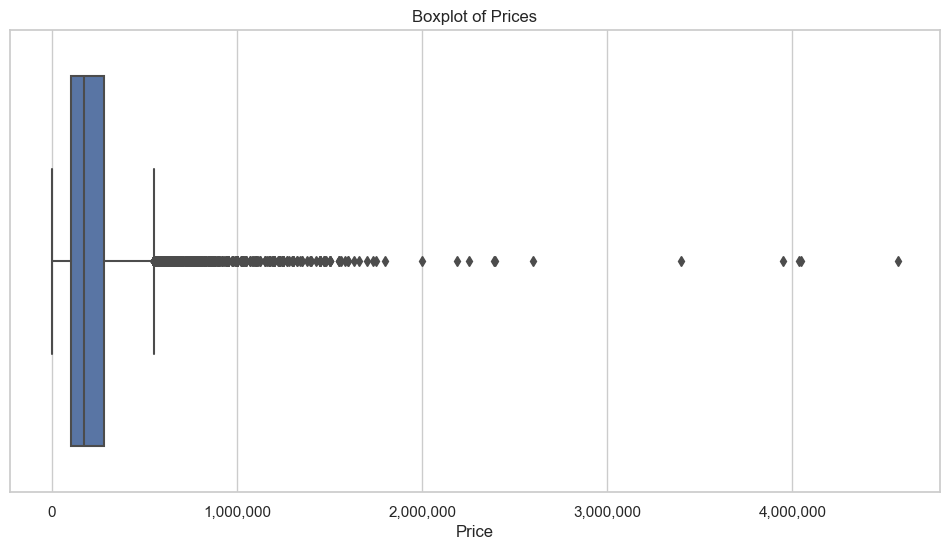

In [331]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Price'])
plt.title('Boxplot of Prices')
plt.xlabel('Price')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

### Model Year

In [332]:
df['ModelYear'].describe()

count   37,200.00
mean     2,017.46
std          5.80
min      1,925.00
25%      2,015.00
50%      2,018.00
75%      2,021.00
max      2,025.00
Name: ModelYear, dtype: float64

this tells us that there are some outliers, as the min is a car from 1925, aswell as some new cars with the model year of 2025. And that we have mostly cars from newer years with a mean of 2017 and and a median of 2018, with a std of about 5

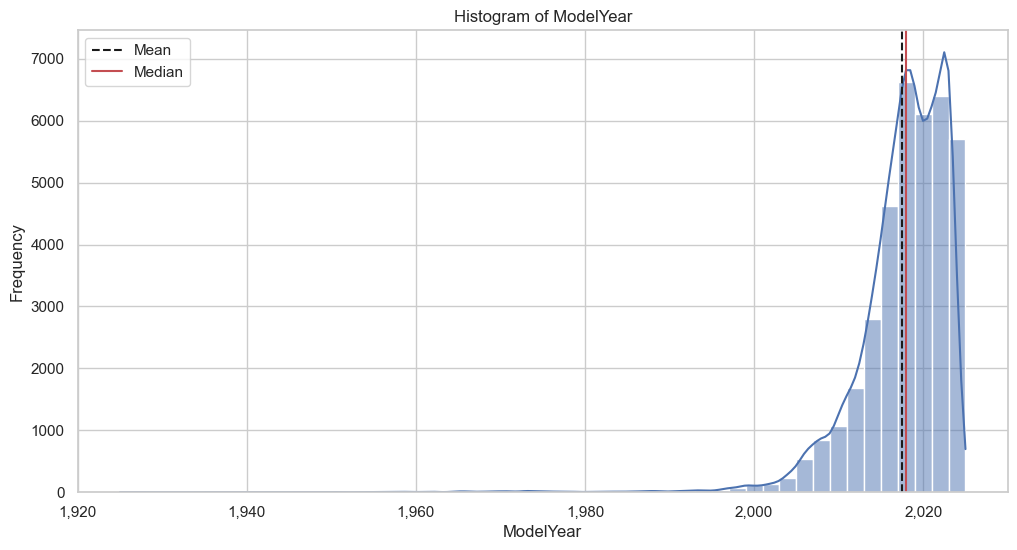

In [333]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['ModelYear'], kde=True, bins=50)
plt.title('Histogram of ModelYear')
plt.xlabel('ModelYear')
plt.ylabel('Frequency')
plt.axvline(df['ModelYear'].mean(), color='k', linestyle='--', label='Mean')
plt.axvline(df['ModelYear'].median(), color='r', linestyle='-', label='Median')
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

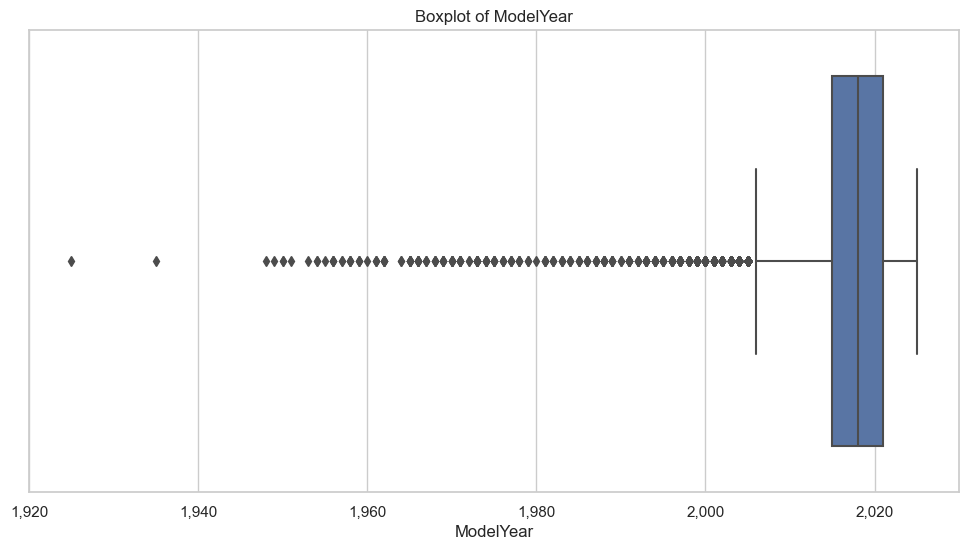

In [334]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['ModelYear'])
plt.title('Boxplot of ModelYear')
plt.xlabel('ModelYear')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

In [335]:
df["Reg"].describe()

count   37,200.00
mean     2,017.37
std          5.77
min      1,925.00
25%      2,015.00
50%      2,018.00
75%      2,021.00
max      2,026.00
Name: Reg, dtype: float64

The 1. registration of the vehicles follows the ModelYear, which makes sense as most of them are registered in the same year as the modelYear

### HorsePower

In [336]:
df["HorsePower"].describe()

count   37,200.00
mean       157.06
std         84.54
min         11.00
25%        100.00
50%        136.00
75%        190.00
max        685.00
Name: HorsePower, dtype: float64

this again tells us that we have some outliers in the upper and lower end with a max of 685hp and a min of 11hp. a mean of 157hp with a median of 136 tells us that we have have most of our cars have moderate horsePower. The std of 84 which is relativly high, tells us that we there is a varaity of diffrent powers.

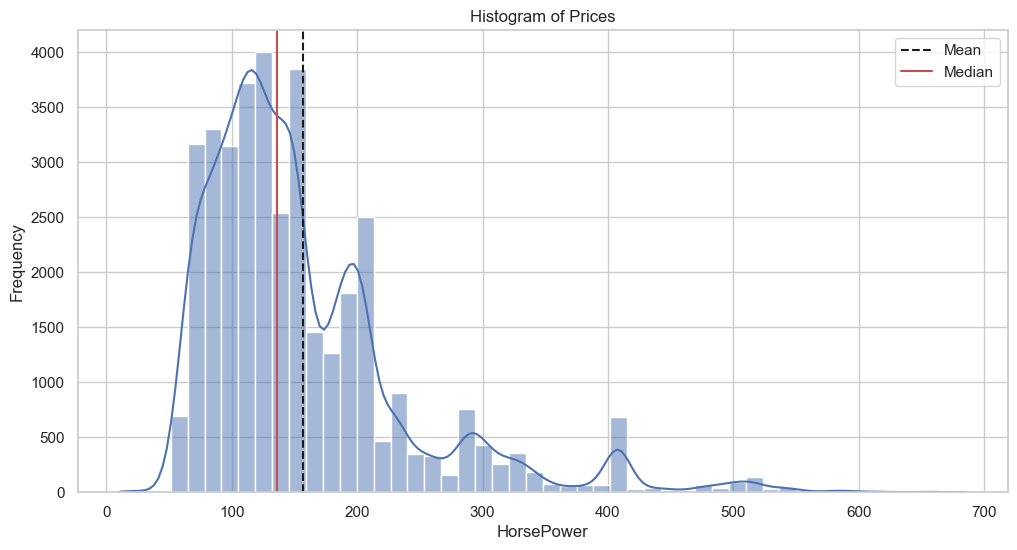

In [337]:
# Set the style for the plots
sns.set(style="whitegrid")

# Histogram for Price
plt.figure(figsize=(12, 6))
sns.histplot(df['HorsePower'], kde=True, bins=50)
plt.title('Histogram of Prices')
plt.xlabel('HorsePower')
plt.ylabel('Frequency')
plt.axvline(df['HorsePower'].mean(), color='k', linestyle='--', label='Mean')
plt.axvline(df['HorsePower'].median(), color='r', linestyle='-', label='Median')
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

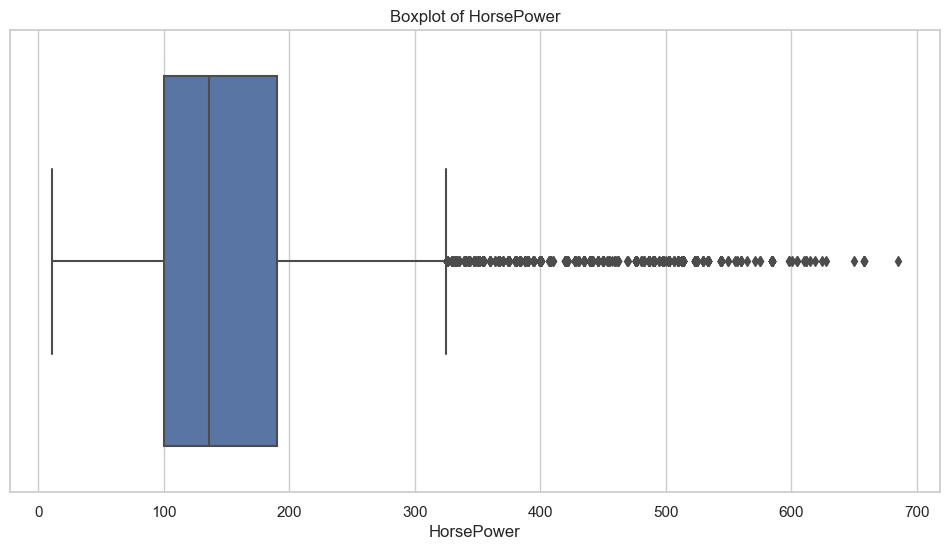

In [338]:
# Boxplot for Price
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['HorsePower'])
plt.title('Boxplot of HorsePower')
plt.xlabel('HorsePower')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

### Make 

In [339]:
make_counts = df['Make'].value_counts()

print(make_counts)

VW            5266
Mercedes      2961
Peugeot       2749
Ford          2333
Skoda         2267
BMW           2155
Audi          2067
Renault       1767
Hyundai       1738
Citroën       1724
Opel          1587
Kia           1526
Volvo         1151
Nissan        1107
Toyota        1047
Fiat           974
Suzuki         974
Mazda          854
Seat           853
Tesla          524
MINI           430
Polestar       375
Cupra          255
Honda          216
Alfa Romeo     115
Jaguar         113
Land Rover      72
Name: Make, dtype: int64


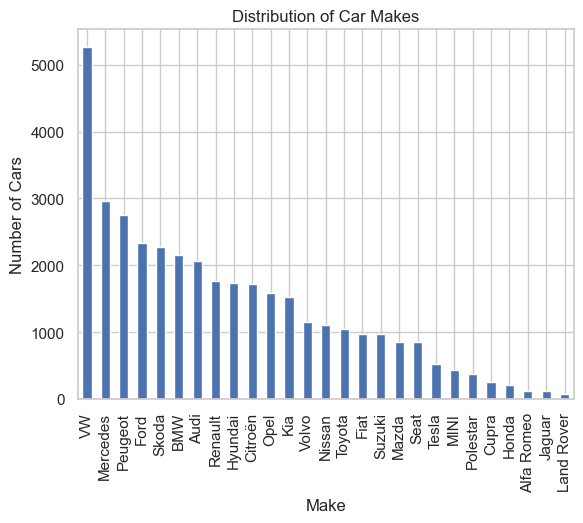

In [340]:
make_counts.plot(kind='bar')

plt.title('Distribution of Car Makes')
plt.xlabel('Make')
plt.ylabel('Number of Cars')

plt.show()

### Model

In [341]:
model_counts = df['Model'].value_counts().head(20)

print(model_counts)

Polo        705
208         703
Octavia     593
Qashqai     581
Fiesta      579
Focus       545
Golf VII    531
ID.4        524
2           516
ID.3        475
Fabia       475
C3          455
308         454
Up!         416
Model 3     401
Passat      380
Enyaq       372
XC40        363
Astra       347
i10         347
Name: Model, dtype: int64


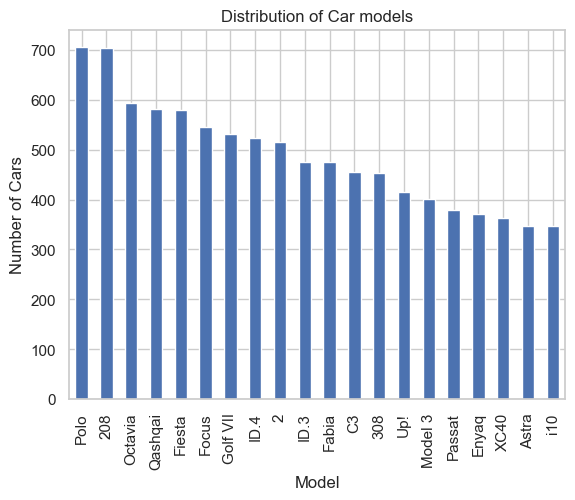

In [342]:
model_counts.plot(kind='bar')

plt.title('Distribution of Car models')
plt.xlabel('Model')
plt.ylabel('Number of Cars')

plt.show()

### FuelType

In [343]:
fuelType_counts = df['FuelType'].value_counts()

print(fuelType_counts)

Benzin    18573
Diesel     9934
El         8693
Name: FuelType, dtype: int64


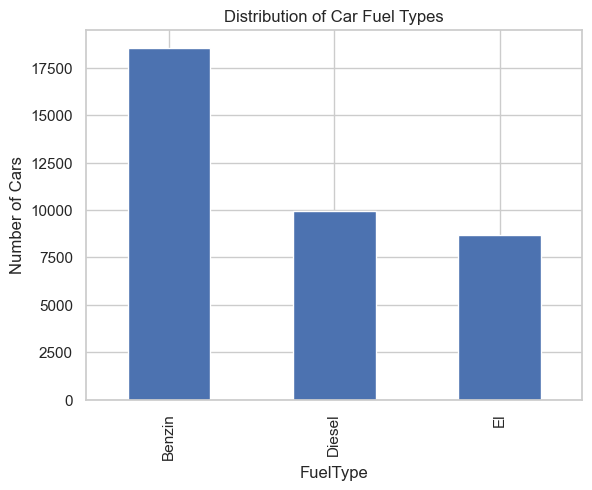

In [344]:
fuelType_counts.plot(kind='bar')

plt.title('Distribution of Car Fuel Types')
plt.xlabel('FuelType')
plt.ylabel('Number of Cars')

plt.show()

### GearType

In [345]:
gearType_counts = df['GearType'].value_counts()

print(gearType_counts)

A    20562
M    16638
Name: GearType, dtype: int64


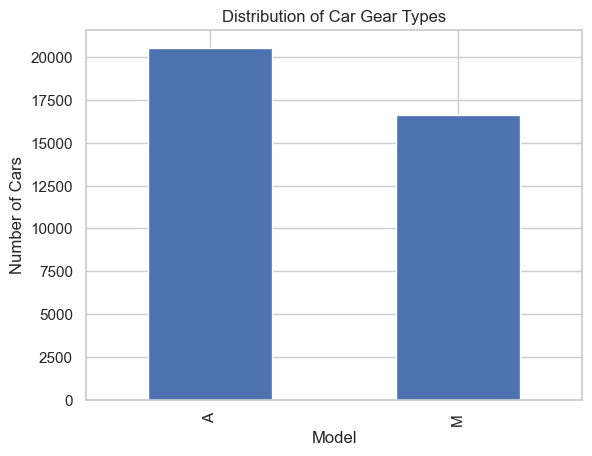

In [346]:
gearType_counts.plot(kind='bar')

plt.title('Distribution of Car Gear Types')
plt.xlabel('Model')
plt.ylabel('Number of Cars')

plt.show()

In [347]:
# Correlation between numerical columns

<Axes: >

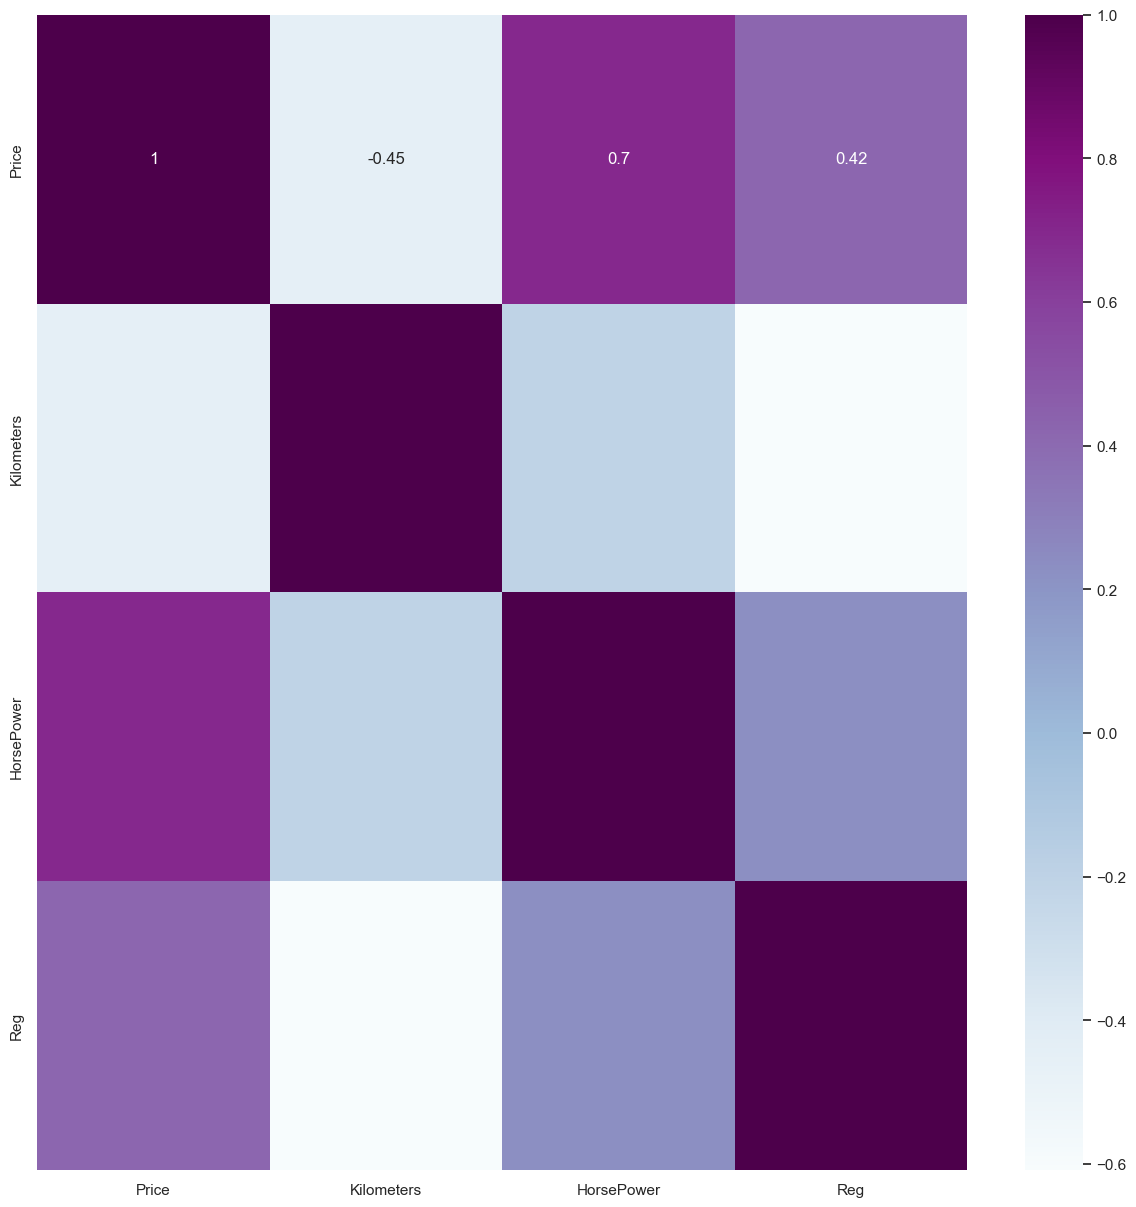

In [348]:
plt.figure(figsize = (15, 15))
cols = ['Price', 'Kilometers', 'HorsePower', 'Reg']
heatmap_data = df[cols].corr()

sns.heatmap(heatmap_data,cmap="BuPu", annot = True)

## Data Cleaning

### Removing outliers
we saw that we had a few outliers in the previous steps, here we will remove them

### Price

In [349]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [350]:
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

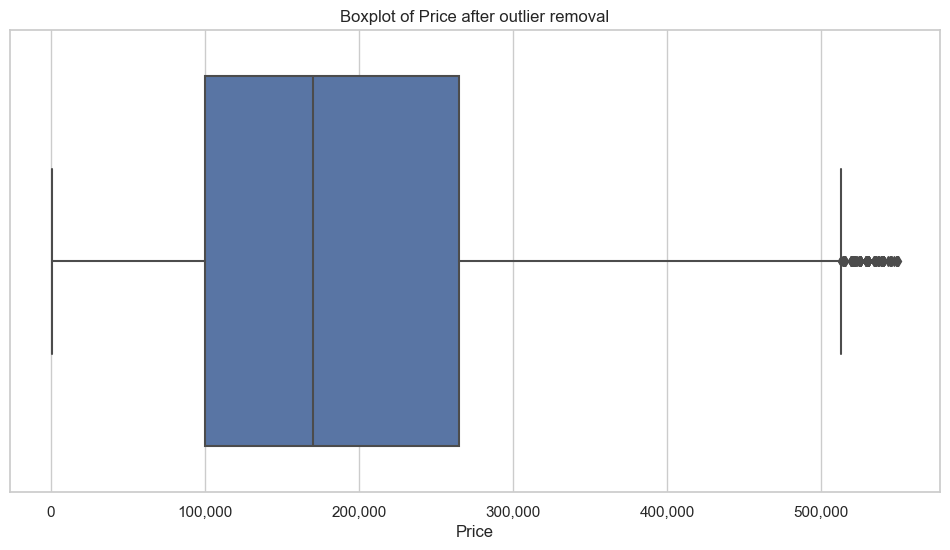

In [351]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Price'])
plt.title('Boxplot of Price after outlier removal')
plt.xlabel('Price')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

### Kilometers

Start by checking if we already removed the outliers in the step above

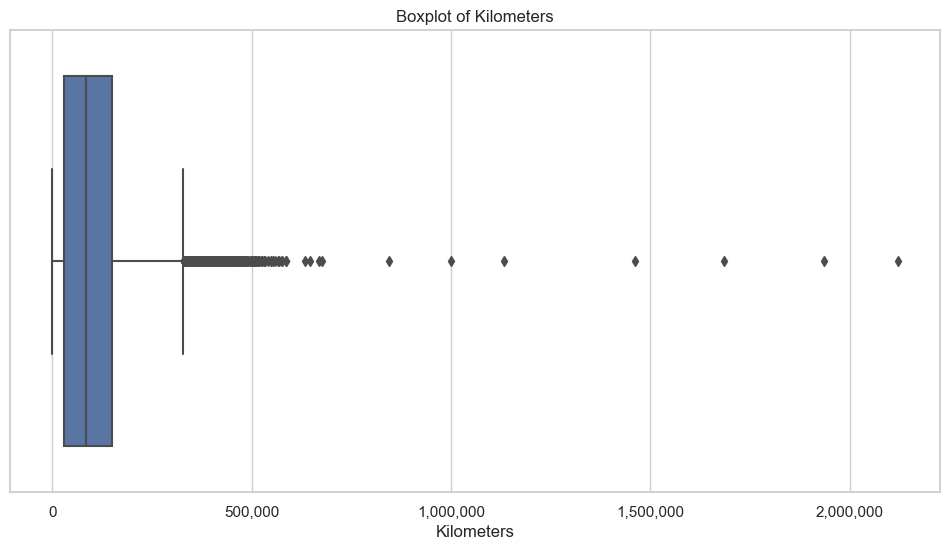

In [352]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Kilometers'])
plt.title('Boxplot of Kilometers')
plt.xlabel('Kilometers')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

There are still outliers to remove

In [353]:
Q1 = df['Kilometers'].quantile(0.25)
Q3 = df['Kilometers'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [354]:
df = df[(df['Kilometers'] >= lower_bound) & (df['Kilometers'] <= upper_bound)]

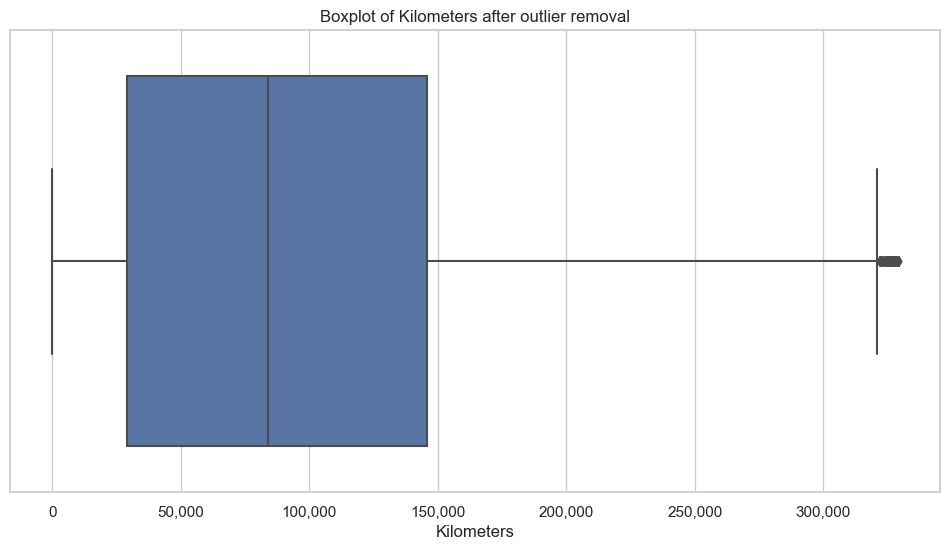

In [355]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Kilometers'])
plt.title('Boxplot of Kilometers after outlier removal')
plt.xlabel('Kilometers')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

### ModelYear

Start by checking if we already removed the outliers in the steps above

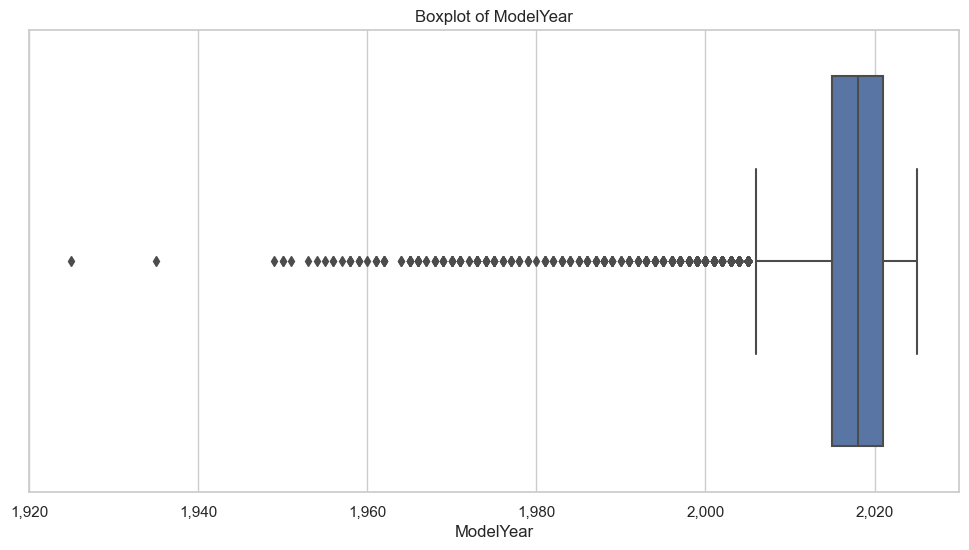

In [356]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['ModelYear'])
plt.title('Boxplot of ModelYear')
plt.xlabel('ModelYear')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

In [357]:
Q1 = df['ModelYear'].quantile(0.25)
Q3 = df['ModelYear'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [358]:
df = df[(df['ModelYear'] >= lower_bound) & (df['ModelYear'] <= upper_bound)]

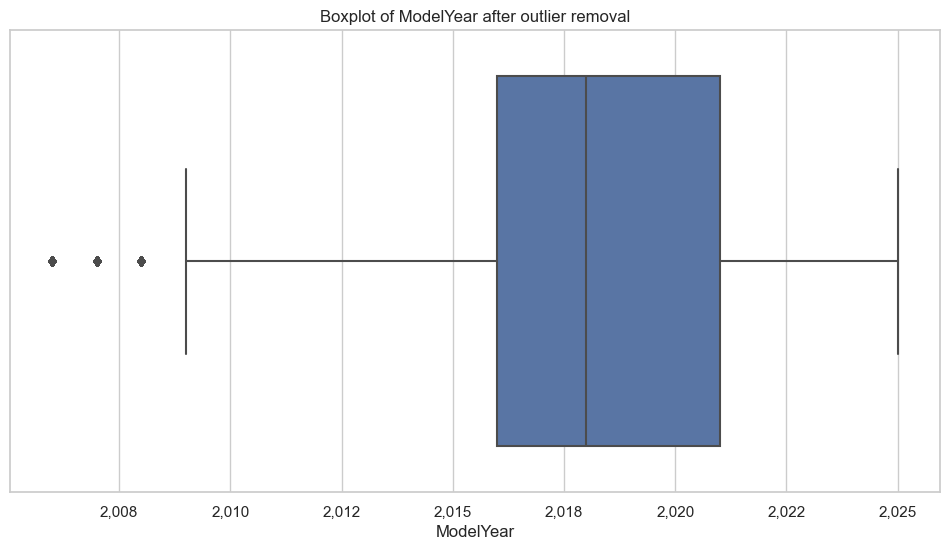

In [359]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['ModelYear'])
plt.title('Boxplot of ModelYear after outlier removal')
plt.xlabel('ModelYear')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

### HorsePower

Start by checking if we already removed the outliers in the step above

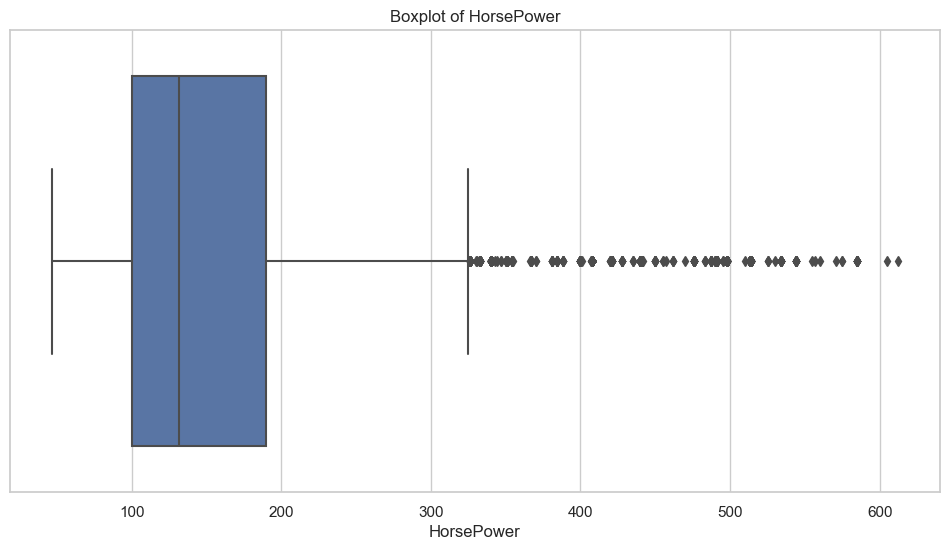

In [360]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['HorsePower'])
plt.title('Boxplot of HorsePower')
plt.xlabel('HorsePower')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_format))
plt.show()

Altough there are some outliers, we have decided to keep them, as a lot of the elecric cars would get thrown out

In [361]:
#Checking how many we removed

print(len(df))

34748


### changing names to lower, for concistency between motorregister and bilbasen

In [362]:
df["Make"] = df["Make"].apply(lambda x: x.lower())

In [363]:
df["Model"] = df["Model"].apply(lambda x: x.lower())

# Prediction

## train test split

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [414]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=50)

### Transformers for pipeline

In [415]:
numerical_features = ['ModelYear', 'Reg', 'Kilometers', 'HorsePower']
categorical_features = ['Make', 'Model', 'GearType', 'FuelType']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Linear Regression

In [416]:
lr = LinearRegression()


lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr)
])

lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ModelYear', 'Reg',
                                                   'Kilometers',
                                                   'HorsePower']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Model', 'GearType',
                                                   'FuelType'])])),
                ('model', LinearRegression())])

In [417]:
y_pred = lr_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 33795.66949106952
R² Score: 0.9170079732100035


In [418]:
cv_r2_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()

print(f'Mean Cross-Validated R² Score: {mean_cv_r2}')
print(f'Standard Deviation of Cross-Validated R² Score: {std_cv_r2}')

Mean Cross-Validated R² Score: 0.6141839672183136
Standard Deviation of Cross-Validated R² Score: 0.0998619092218187


## Descision Tree regressor

In [419]:
dt = DecisionTreeRegressor()
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', dt)
])
dt_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ModelYear', 'Reg',
                                                   'Kilometers',
                                                   'HorsePower']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Model', 'GearType',
                                                   'FuelType'])])),
                ('model', DecisionTreeRegressor())])

In [420]:
y_pred = dt_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 36429.51672892962
R² Score: 0.9035680203840744


In [421]:
cv_r2_scores = cross_val_score(dt_pipeline, X, y, cv=5, scoring='r2')
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()

print(f'Mean Cross-Validated R² Score: {mean_cv_r2}')
print(f'Standard Deviation of Cross-Validated R² Score: {std_cv_r2}')

Mean Cross-Validated R² Score: 0.7360065680512395
Standard Deviation of Cross-Validated R² Score: 0.10265819697313285


In [422]:
with open("./models/dt_pipeline.pkl", 'wb') as file:  
    pickle.dump(best_dt, file)

### RandomizedSearchCV - tuning hyper paramters

In [423]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])


In [424]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'model__criterion': ['squared_error', 'friedman_mse'],
    'model__splitter': ['best'],
    'model__max_depth': [10, 20, 30, 40, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

In [425]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['ModelYear',
                                                                                'Reg',
                                                                                'Kilometers',
                                                                                'HorsePower']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Make',
                                                                                'Model',
                                                                                'GearType',
                                                                                'FuelType'])])),
                                             ('model',
                                              DecisionTreeRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__criterion': ['squared_error',
                                                             'friedman_mse'],
                                        'model__max_depth': [10, 20, 30, 40,
                                                             None],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2],
                                        'model__min_samples_split': [2, 5],
                                        'model__splitter': ['best']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [426]:
best_params = random_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'model__splitter': 'best', 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'friedman_mse'}


In [427]:
best_dt = random_search.best_estimator_
best_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ModelYear', 'Reg',
                                                   'Kilometers',
                                                   'HorsePower']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Model', 'GearType',
                                                   'FuelType'])])),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       max_features='sqrt',
                                       min_samples_split=5))])

In [430]:
y_pred = best_dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 37292.12652442204
R² Score: 0.898947151401159


In [431]:
cv_r2_scores = cross_val_score(best_dt, X, y, cv=5, scoring='r2')
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()

print(f'Mean Cross-Validated R² Score: {mean_cv_r2}')
print(f'Standard Deviation of Cross-Validated R² Score: {std_cv_r2}')

Mean Cross-Validated R² Score: 0.6403908892696473
Standard Deviation of Cross-Validated R² Score: 0.09565979122146503


In [432]:
with open("./models/Randomized_dt_pipeline.pkl", 'wb') as file:  
    pickle.dump(best_dt, file)

## RandomForestRegressor

In [433]:
rf = RandomForestRegressor()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])


rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 28962.72851544217
R² Score: 0.9390472633688869


In [434]:
r2_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')

mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()

print(f'Mean Cross-Validated R² Score: {mean_r2}')
print(f'Standard Deviation of Cross-Validated R² Score: {std_r2}')

Mean Cross-Validated R² Score: 0.8062142066603168
Standard Deviation of Cross-Validated R² Score: 0.08602233186289658


In [437]:
with open("./models/rf_pipeline.pkl", 'wb') as file:  
    pickle.dump(rf_pipeline, file)

### Gridsearch - tuning hyper paramters

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
rf_rs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__criterion': ['squared_error', 'absolute_error'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5, 10],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf_rs_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [494]:

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')



Best parameters: {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [493]:
# Step 4: Train the model with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_features=2, n_estimators=300)

In [495]:
# Step 5: Predict on the test set
y_pred = best_rf.predict(X_test)

# Step 6: Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')



Root Mean Squared Error: 28571.181649801652
R² Score: 0.9392605978993726


In [496]:
# Step 7: Cross-validation
cv_r2_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()

print(f'Mean Cross-Validated R² Score: {mean_cv_r2}')
print(f'Standard Deviation of Cross-Validated R² Score: {std_cv_r2}')

Mean Cross-Validated R² Score: 0.8007050344878079
Standard Deviation of Cross-Validated R² Score: 0.07332856795160914


In [499]:
with open("./models/randomForestRegressor_gridsearch.pkl", 'wb') as file:  
    pickle.dump(best_rf, file)

In [121]:
print(X.columns)

Index(['ModelYear', 'Reg', 'Kilometers', 'HorsePower', 'Make_Alfa Romeo',
       'Make_Audi', 'Make_BMW', 'Make_Citroën', 'Make_Cupra', 'Make_Fiat',
       ...
       'Model_ix20', 'Model_ix35', 'Model_ë-Berlingo', 'Model_ë-C4',
       'Model_ë-C4 X', 'GearType_A', 'GearType_M', 'FuelType_Benzin',
       'FuelType_Diesel', 'FuelType_El'],
      dtype='object', length=684)


684
